### Import Packages


In [1]:
import os
#import csv
#import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Module for Google Drive
#from google.colab import drive

# Module for Importing Images
from PIL import Image 

import torch
import torchvision
from torchvision import models
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.9.0


### Import your drive's contents!

In [3]:
#drive.mount('/content/drive')

### Let's define some path, and our PokeMon dataset
- Put the "pokemon" folder to somewhere of your Google Drive, and define the train/test path to "train_path" and "test_path"
- To 'model_dir', put the drive's directory path that you want to save your model

In [13]:
train_path = '/Volumes/TOSHIBA_EXT_1/PokemonClass/pokemon/train'
test_path = '/Volumes/TOSHIBA_EXT_1/PokemonClass/test_1'
model_dir = '/Volumes/TOSHIBA_EXT_1/PokemonClass/models'    #./drive/MyDrive/Path/To/Save/Your/Model
#train_path = input('Please enter the path to the training set: ')
#test_path = input('Please enter the path to the test set: ')
#model_dir = input('Please enter the path to the model directory: ')
classes = ['bug', 'electric', 'fighting', 'fire', 'flying', 'grass', 'ground', 'phychic', 'poison', 'water']

#### Without augmentations

In [36]:
class PokemonDataset(Dataset):
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        # organize path information for __len__ and __getitem__
        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))

        # Add some tranforms for data augmentation.
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)
        input = self.normalize_transform(original_img)

        sample = dict()
        sample['input'] = input
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

#### With augmentations

In [43]:
class PokemonDataset(Dataset):
    
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        ### add transforms for data augmentation
        self.tensor_transform = T.ToTensor()
        self.normalize_transforms = T.Normalize(mean = [0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
        ### other transforms
        torch.manual_seed(2021) # to ensure reproducibility
        self.random_rotation = T.RandomRotation(degrees=15)
        self.random_vert_flip = T.RandomVerticalFlip(p=0.2)
        self.random_hor_flip = T.RandomHorizontalFlip(p=0.2)
        ### add them in a list for random transform choice
        transforms = [self.random_rotation, self.random_vert_flip, self.random_hor_flip]
        ### choose casual augmentation and add Tensor Transformation
        #self.random_transform = T.RandomChoice(transforms=transforms)
        self.random_transform = T.Compose([T.RandomChoice(transforms=transforms), self.tensor_transform])

        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c,fp)
                self.img_path_label.append((full_fp,c,self.classes.index(c)))
                if fp[-8] != "_":
                    mod_url = f'{full_fp[:-4]}_mod.jpg'
                    self.img_path_label.append((mod_url,c,self.classes.index(c)))
        
        n = len(self.img_path_label)
        for i in range(1,n,2):
            fp = self.img_path_label[i-1][0]
            img= Image.open(fp)
            #og_img = self.random_transform(img)
            #og_img = self.tensor_transform(og_img).permute(1,2,0)
            og_img = self.random_transform(img).permute(1,2,0)
            tmp = self.img_path_label[i][0]
            plt.imsave(tmp, og_img.numpy(), format='jpg')

    def __len__(self):
        return len(self.img_path_label)
    

    def __getitem__(self, idx):
        
        (fp, class_name, class_label) = self.img_path_label[idx]
        img= Image.open(fp)
        

        og_img = self.tensor_transform(img)
        input = self.normalize_transforms(og_img)

        # get sample dictionary
        sample = {
            'input':input,
            'original_img': og_img,
            'target': class_label,
            'class_name': class_name
        }

        return sample

### Set DataSet and DataLoader

In [44]:
batch_size = 64

train_dataset = PokemonDataset(train_path, classes)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = PokemonDataset(test_path, classes)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(classes)

In [12]:
#print(train_dataset.img_path_label[1])

('/Volumes/TOSHIBA_EXT_1/PokemonClass/pokemon/train/bug/0001.jpg', 'bug', 0)


### Take a sample and try to look at the one

In [46]:
sample = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


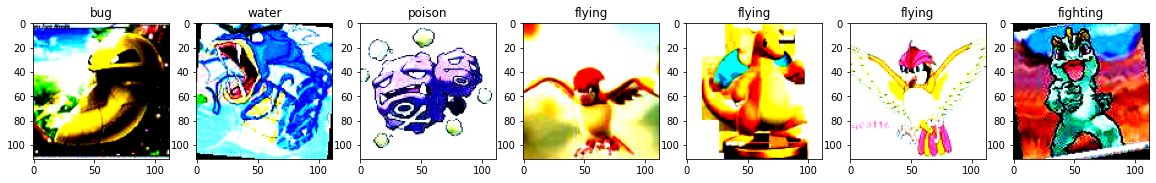

In [47]:
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(7):
    ax[i].imshow(sample['input'][i].permute(1, 2, 0))
    ax[i].set_title(sample['class_name'][i])

### Choose your device - use GPU or not?

In [18]:
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current Device : {}'.format(device))

Current Device : cpu


### Define the model with the pre-trained ResNet

#### ResNet50

In [60]:
### MODEL: ResNet 50

class Model(nn.Module):
    def __init__(self, num_classes=len(classes), pretrained=True):
        super(Model, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        # freeze the first layer
        for param in self.model.layer1.parameters():
          param.requires_grad = False
        # add fully-connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Dropout(0.3),
                                      nn.Linear(num_ftrs, num_classes))

    def forward(self, x):
        return self.model(x)

### Create a model and its optimizer


In [68]:
model = Model()
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-04)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [30]:
print(model)

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [21]:
model(sample['input'].to(device)).shape

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([64, 10])

### Define functions for train/test



In [62]:
def train(model, optimizer, sample, scheduler):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    input = sample['input'].float().to(device)
    target = sample['target'].long().to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)
    
    top_val, top_idx = torch.topk(pred, 1)

    num_correct = torch.sum(top_idx == target.view(-1, 1))
    
    pred_loss.backward()
       
    optimizer.step()
    scheduler.step()

    return pred_loss.item(), num_correct.item()

In [63]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return pred_loss.item(), num_correct.item()

### Run Training

#### without CV

In [69]:
max_epoch = 50
save_stride = 5
tmp_path = './checkpoint.pth'
max_accu = -1
for epoch in tqdm(range(max_epoch)):
    print("EPOCH: {}".format(epoch +1))
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    with tqdm(total=len(train_dataloader)) as pbar:
        for idx, sample in enumerate(train_dataloader):
            curr_loss, num_correct = train(model, optimizer, sample, scheduler)
            train_loss += curr_loss / len(train_dataloader)
            train_accu += num_correct / len(train_dataset)
            pbar.update(1)

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model' : Model(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    # Save the checkpoint - you can try to save the "best" model with the validation accuracy/loss
    torch.save(checkpoint, tmp_path)
    if (epoch+1) % save_stride == 0:
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_resnet50_{}_epoch_newscheduler.pth'.format(epoch+1)))
    torch.save(checkpoint, os.path.join(model_dir, 'pokemon_resnet50_recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    with tqdm(total=len(test_dataloader)) as pbar:
        for idx, sample in enumerate(test_dataloader):
            curr_loss, num_correct = test(model, sample)
            test_loss += curr_loss / len(test_dataloader)
            test_accu += num_correct / len(test_dataset)
            pbar.update(1)


    max_accu = max(test_accu, max_accu)
    if max_accu == test_accu:
        # Save your best model to the checkpoint
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_resnet50_best.pth'))

    # These Lines would make you update your Google Drive after the saving.
    #drive.flush_and_unmount()
    #drive.mount('/content/drive')

    print(train_accu, test_accu)
    print(f"----------------- MAX ACCURACY: {round(max_accu,3)} -----------------")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.7868052609249039 0.7333333333333334
----------------- MAX ACCURACY: 0.733 -----------------
EPOCH: 2


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9779380568519299 0.7333333333333334
----------------- MAX ACCURACY: 0.733 -----------------
EPOCH: 3


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9836656767076788 0.7083333333333333
----------------- MAX ACCURACY: 0.733 -----------------
EPOCH: 4


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9821807382265587 0.7416666666666667
----------------- MAX ACCURACY: 0.742 -----------------
EPOCH: 5


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9832414085702159 0.725
----------------- MAX ACCURACY: 0.742 -----------------
EPOCH: 6


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9840899448451417 0.7333333333333334
----------------- MAX ACCURACY: 0.742 -----------------
EPOCH: 7


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9826050063640216 0.7083333333333333
----------------- MAX ACCURACY: 0.742 -----------------
EPOCH: 8


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9836656767076788 0.7416666666666667
----------------- MAX ACCURACY: 0.742 -----------------
EPOCH: 9


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.982817140432753 0.725
----------------- MAX ACCURACY: 0.742 -----------------
EPOCH: 10


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9834535426389474 0.7416666666666667
----------------- MAX ACCURACY: 0.742 -----------------
EPOCH: 11


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9840899448451417 0.7666666666666666
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 12


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.982817140432753 0.725
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 13


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9832414085702159 0.7333333333333334
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 14


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9836656767076788 0.7333333333333334
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 15


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9823928722952902 0.7416666666666667
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 16


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9834535426389474 0.7333333333333334
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 17


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9830292745014845 0.7333333333333334
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 18


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9826050063640216 0.7166666666666667
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 19


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9855748833262618 0.7333333333333334
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 20


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9834535426389474 0.7416666666666667
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 21


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9834535426389474 0.7416666666666667
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 22


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9811200678829015 0.7083333333333333
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 23


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9815443360203644 0.7416666666666667
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 24


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0.9821807382265587 0.7333333333333334
----------------- MAX ACCURACY: 0.767 -----------------
EPOCH: 25


  0%|          | 0/74 [00:00<?, ?it/s]

#### With 5-Fold CV (not implemented)

Even with adding the augmentations, the model performed poorly in the context of a 5-Fold cross-validation, with an average accuracy of 0.63 or lower. Therefore, the model was tested in a train-test split and the following code was not implemented. I decided to keep it in the notebook anyway, in case you wanted to check its performance.

In [ ]:
#%pip install scikit-learn
from sklearn import model_selection

n_folds = 5

skfold = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state= 17122021)

for fold, (train_idx, val_idx) in enumerate(skfold.split(train_dataset)):
  print(f"------------------------- fold no. {fold + 1} -------------------------")
  
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

  train_loader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=batch_size,
                      sampler=train_subsampler)
  val_loader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=batch_size,
                      sampler=val_subsampler)
  
  #model.apply(reset_weights)

  max_epoch = 30
  save_stride = 5
  tmp_path = './checkpoint.pth'
  max_accu = -1
  for epoch in tqdm(range(max_epoch)):
      print(f"EPOCH {epoch+1}")

      ###Train Phase
      
      # Initialize Loss and Accuracy
      train_loss = 0.0
      train_accu = 0.0

      # Load the saved MODEL AND OPTIMIZER after evaluation.
      if epoch > 0:
          checkpoint = torch.load(tmp_path)
          model.load_state_dict(checkpoint['model_state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      
      # Iterate over the train_loader
      with tqdm(total=len(train_loader)) as pbar:
          for idx, sample in enumerate(train_loader):
              curr_loss, num_correct = train(model, optimizer, sample, scheduler)
              train_loss += curr_loss / len(train_loader)
              train_accu += num_correct / len(train_loader)
              pbar.update(1)

      # save the model and optimizer's information before the evaulation
      checkpoint = {
          'model' : Model(),
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
      }
      
      # Save the checkpoint - you can try to save the "best" model with the validation accuracy/loss
      torch.save(checkpoint, tmp_path)
      if (epoch+1) % save_stride == 0:
          torch.save(checkpoint, os.path.join(model_dir, f'pokemon_resnet50_cv_{fold+1}_{epoch+1}.pth'))
      torch.save(checkpoint, os.path.join(model_dir, f'pokemon_resnet50_cv_{fold+1}_recent.pth'))
      
      ### Test Phase
      # Initialize Loss and Accuracy
      test_loss = 0.0
      test_accu = 0.0

      # Iterate over the test_dataloader
      with tqdm(total=len(val_loader)) as pbar:
          for idx, sample in enumerate(val_loader):
              curr_loss, num_correct = test(model, sample)
              test_loss += curr_loss / len(val_loader)
              test_accu += num_correct / len(val_loader)
              pbar.update(1)


      max_accu = max(test_accu, max_accu)
      if max_accu == test_accu:
          # Save your best model to the checkpoint
          torch.save(checkpoint, os.path.join(model_dir, f'pokemon_resnet50_cv_{fold+1}_fold_best.pth'))

      # These Lines would make you update your Google Drive after the saving.
      #drive.flush_and_unmount()
      #drive.mount('/content/drive')

      print(f"Epoch {epoch+1}:\t",round(train_accu,3), round(test_accu,3))
      print(f"----------------- MAX FOLD {fold +1} ACCURACY: {round(max_accu,3)} -----------------")